In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
train_df = pd.read_csv('playground-series-s4e12/train.csv')
test_df = pd.read_csv('playground-series-s4e12/test.csv')
train_df.describe()
from sklearn.metrics import mean_squared_log_error



In [2]:
print("\nNumber of NaN values in each column:")
for i, col in enumerate(train_df.columns):
    print(f"{i+1}. {col}: {train_df[col].isna().sum()}")


Number of NaN values in each column:
1. id: 0
2. Age: 18705
3. Gender: 0
4. Annual Income: 44949
5. Marital Status: 18529
6. Number of Dependents: 109672
7. Education Level: 0
8. Occupation: 358075
9. Health Score: 74076
10. Location: 0
11. Policy Type: 0
12. Previous Claims: 364029
13. Vehicle Age: 6
14. Credit Score: 137882
15. Insurance Duration: 1
16. Policy Start Date: 0
17. Customer Feedback: 77824
18. Smoking Status: 0
19. Exercise Frequency: 0
20. Property Type: 0
21. Premium Amount: 0


In [3]:
def preprocess_data(df):
    # Drop ID column
    df = df.drop(columns='id')
    
    # Normalize numerical columns
    def normalize(column):
        return (column - column.min()) / (column.max() - column.min()) * 2 - 1

    # Normalize Age, Annual Income, Number of Dependents, Health Score, Previous Claims, Vehicle Age, Credit Score, Insurance Duration
    numerical_columns = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 
                         'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']
    for col in numerical_columns:
        df[col] = normalize(df[col])

    # Convert categorical columns
    df['Gender'] = df['Gender'].map({'Female': -1, 'Male': 1})
    df['Marital Status'] = df['Marital Status'].map({'Single': -1, 'Married': 0, 'Divorced': 1})
    df['Location'] = df['Location'].map({'Urban': -1, 'Rural': 0, 'Suburban': 1})
    df['Policy Type'] = df['Policy Type'].map({'Basic': -1, 'Comprehensive': 0, 'Premium': 1})
    df['Smoking Status'] = df['Smoking Status'].map({'No': -1, 'Yes': 1})
    df['Exercise Frequency'] = df['Exercise Frequency'].map({'Rarely': -1, 'Monthly': -0.33, 'Weekly': 0.33, 'Daily': 1})
    df['Property Type'] = df['Property Type'].map({'Apartment': -1, 'Condo': 0, 'House': 1})

    # Convert Education Level into four classes
    df['Education Level'] = df['Education Level'].map({'High School': -1, "Bachelor's": -0.33, "Master's": 0.33, 'PhD': 1})

    # Convert Occupation to numerical values between -1 and 1
    occupation_mapping = {value: idx for idx, value in enumerate(df['Occupation'].unique())}
    df['Occupation'] = df['Occupation'].map(occupation_mapping)
    df['Occupation'] = normalize(df['Occupation'])

    # Extract date features
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Start Year'] = normalize(df['Policy Start Date'].dt.year)
    df['Start Month'] = normalize(df['Policy Start Date'].dt.month)
    df['Start Day'] = normalize(df['Policy Start Date'].dt.day)
    df = df.drop(columns='Policy Start Date')

    df['Customer Feedback'] = df['Customer Feedback'].map({
        'Poor': -1,
        'Average': 0,
        'Good': 1
    })
    # Create interaction features
    df['Age_Annual_Income'] = normalize(df['Age'] * df['Annual Income'])
    df['Health_Credit_Score'] = normalize(df['Health Score'] * df['Credit Score'])
    df['Vehicle_Age_Annual_Income'] = normalize(df['Vehicle Age'] * df['Annual Income'])
    df['Previous_Claims_Health_Score'] = normalize(df['Previous Claims'] * df['Health Score'])
    df['Dependents_Annual_Income'] = normalize(df['Number of Dependents'] * df['Annual Income'])
    
    # Create polynomial features
    df['Age_Squared'] = normalize(df['Age'] ** 2)
    df['Annual_Income_Squared'] = normalize(df['Annual Income'] ** 2)
    df['Credit_Score_Squared'] = normalize(df['Credit Score'] ** 2)
    
    # Create binary features based on thresholds
    df['High_Income'] = df['Annual Income'].apply(lambda x: 1 if x > 0.5 else -1)
    df['Low_Credit_Score'] = df['Credit Score'].apply(lambda x: 1 if x < 0 else -1)
    
    # Create a feature for total score based on multiple factors
    df['Total_Score'] = normalize(df['Health Score'] + df['Credit Score'] + df['Annual Income'])
    
    # Create additional meaningful features
    df['Insurance_Duration_Squared'] = normalize(df['Insurance Duration'] ** 2)
    df['Health_Score_Interaction'] = normalize(df['Health Score'] * df['Smoking Status'])
    df['Age_Health_Score'] = normalize(df['Age'] * df['Health Score'])
    df['Dependents_Health_Score'] = normalize(df['Number of Dependents'] * df['Health Score'])
    df['Credit_Score_Insurance_Duration'] = normalize(df['Credit Score'] * df['Insurance Duration'])

    return df


# Apply preprocessing to both train and test datasets
train_processed = preprocess_data(train_df)
test_processed = preprocess_data(test_df)


print("Processed training data shape:", train_processed.shape)
print("\nFirst few rows of processed training data:")
print(train_processed.head())

train_processed.describe()

Processed training data shape: (1200000, 38)

First few rows of processed training data:
        Age  Gender  Annual Income  Marital Status  Number of Dependents  \
0 -0.956522      -1      -0.866023             0.0                  -0.5   
1 -0.086957      -1      -0.577629             1.0                   0.5   
2 -0.782609       1      -0.658644             1.0                   0.5   
3 -0.869565       1       0.891437             0.0                   0.0   
4 -0.869565       1      -0.471319            -1.0                  -0.5   

   Education Level  Occupation  Health Score  Location  Policy Type  ...  \
0            -0.33   -1.000000     -0.277205        -1            1  ...   
1             0.33   -0.333333     -0.523995         0            0  ...   
2            -1.00   -1.000000      0.585758         1            1  ...   
3            -0.33   -0.333333     -0.686611         0           -1  ...   
4            -0.33   -1.000000     -0.355243         0            1  ...  

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Annual_Income_Squared,Credit_Score_Squared,High_Income,Low_Credit_Score,Total_Score,Insurance_Duration_Squared,Health_Score_Interaction,Age_Health_Score,Dependents_Health_Score,Credit_Score_Insurance_Duration
count,1.181295e+06,1.200000e+06,1.155051e+06,1.181471e+06,1.090328e+06,1.200000e+06,1.200000e+06,1.125924e+06,1.200000e+06,1.200000e+06,...,1.155051e+06,1.062118e+06,1.200000e+06,1.200000e+06,958128.000000,1.199999e+06,1.125924e+06,1.108325e+06,1.022521e+06,1.062117e+06
mean,6.328832e-03,4.285000e-03,-5.633988e-01,-3.069902e-03,4.966854e-03,1.188227e-02,-2.601944e-02,-1.713432e-01,3.359167e-03,2.743333e-03,...,3.040812e-03,-3.939278e-01,-9.217433e-01,-2.013183e-01,-0.195236,-1.586398e-01,-1.065430e-03,-2.716159e-03,3.758952e-04,5.404700e-04
std,5.886935e-01,9.999912e-01,4.290715e-01,8.162359e-01,7.086689e-01,7.409943e-01,7.243192e-01,4.284647e-01,8.160066e-01,8.166964e-01,...,6.344272e-01,5.709593e-01,3.878007e-01,9.795263e-01,0.269960,7.347460e-01,4.615517e-01,2.746909e-01,3.270565e-01,3.569892e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-4.782609e-01,-1.000000e+00,-8.933305e-01,-1.000000e+00,-5.000000e-01,-3.300000e-01,-3.333333e-01,-5.117337e-01,-1.000000e+00,-1.000000e+00,...,-5.692860e-01,-8.929794e-01,-1.000000e+00,-1.000000e+00,-0.381616,-8.750000e-01,-3.705819e-01,-1.471187e-01,-1.837563e-01,-1.985428e-01
50%,0.000000e+00,1.000000e+00,-6.811915e-01,0.000000e+00,0.000000e+00,3.300000e-01,-3.333333e-01,-2.076912e-01,0.000000e+00,0.000000e+00,...,8.026574e-03,-5.685202e-01,-1.000000e+00,-1.000000e+00,-0.201463,-5.000000e-01,-2.263490e-03,-1.882646e-03,-2.138319e-04,0.000000e+00
75%,5.217391e-01,1.000000e+00,-4.048775e-01,1.000000e+00,5.000000e-01,1.000000e+00,3.333333e-01,1.416037e-01,1.000000e+00,1.000000e+00,...,6.052398e-01,-1.642999e-02,-1.000000e+00,1.000000e+00,-0.019674,1.250000e-01,3.688301e-01,1.403902e-01,1.848736e-01,2.008197e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


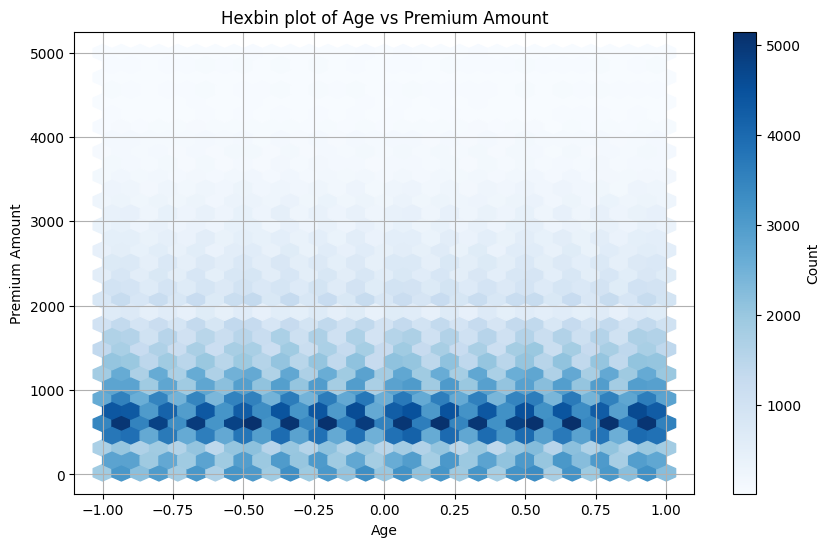

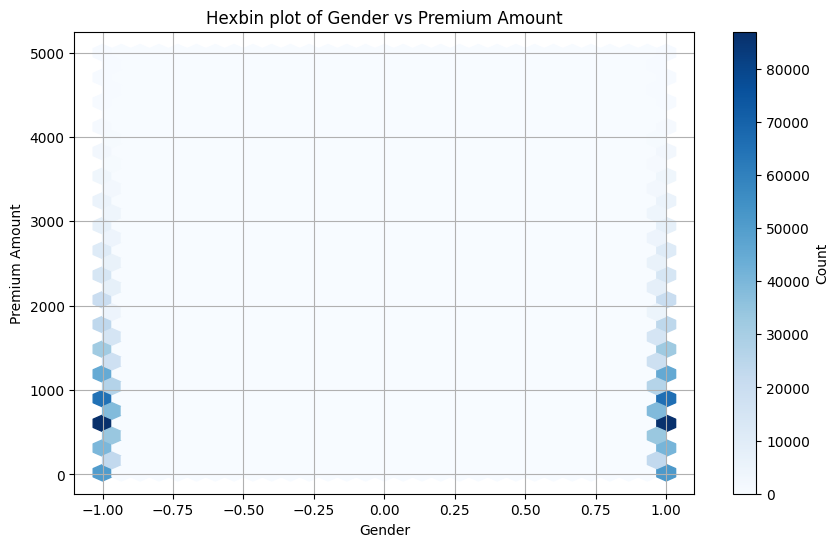

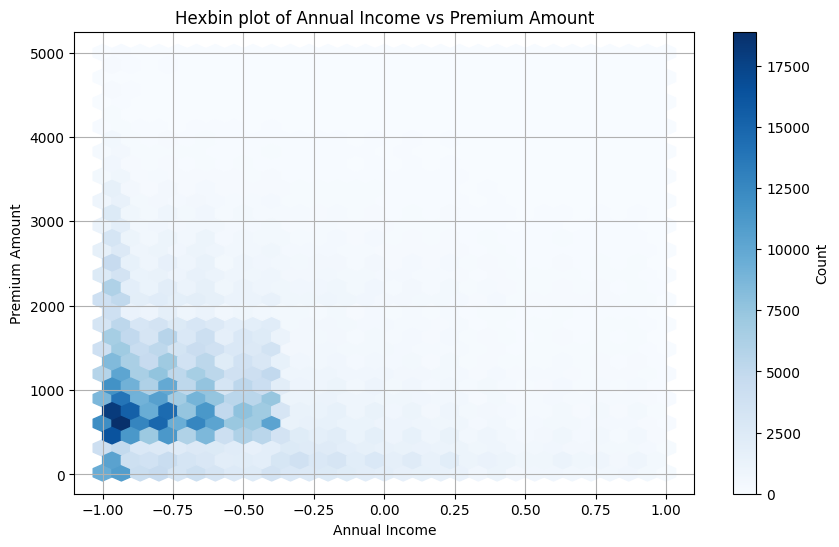

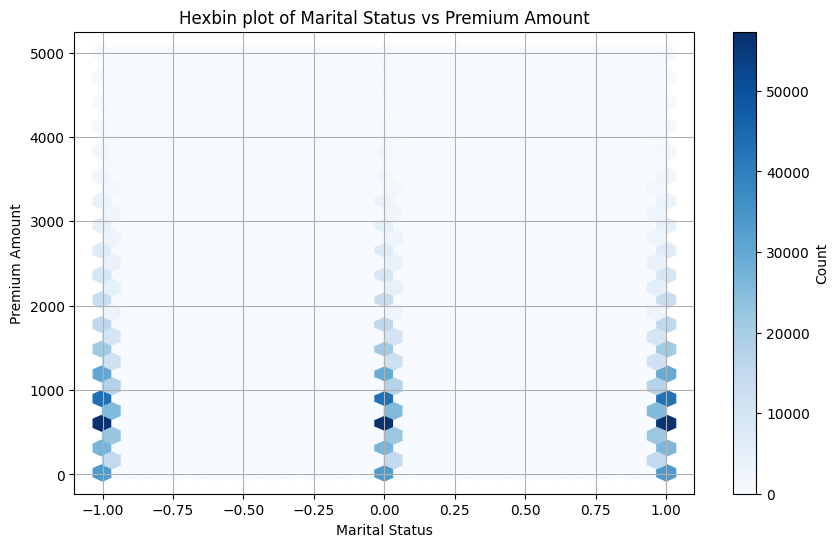

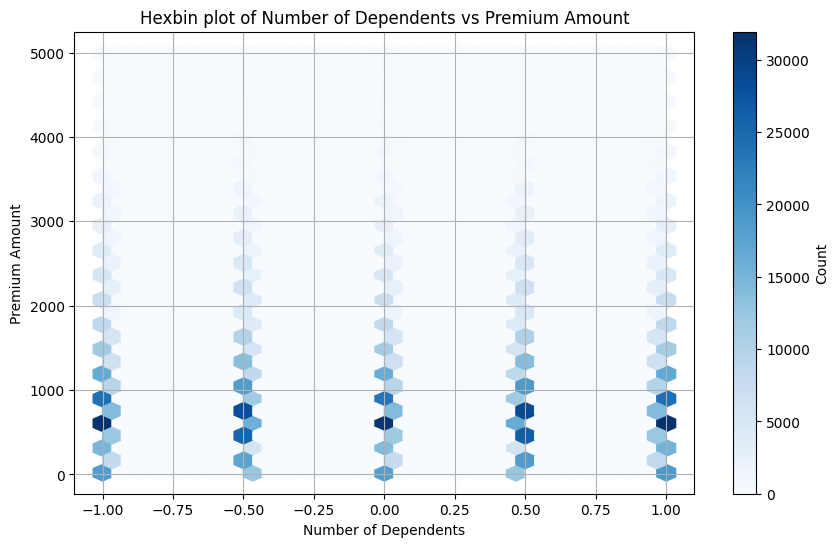

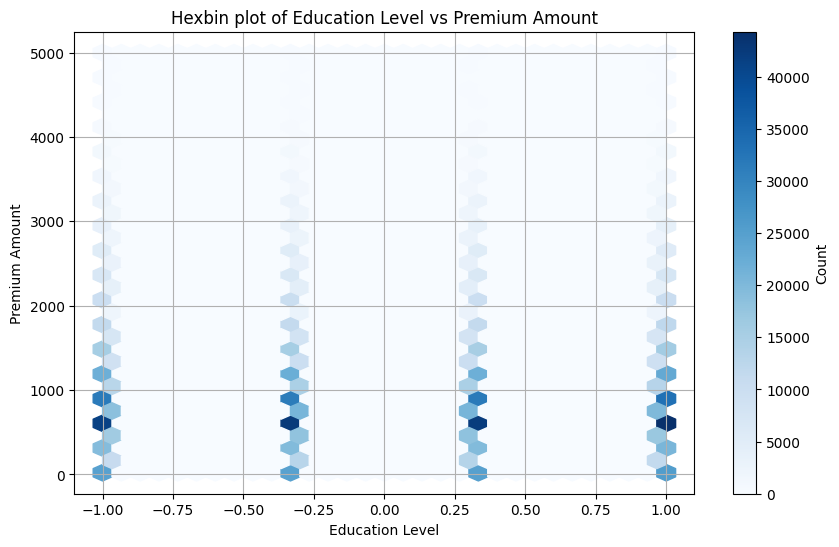

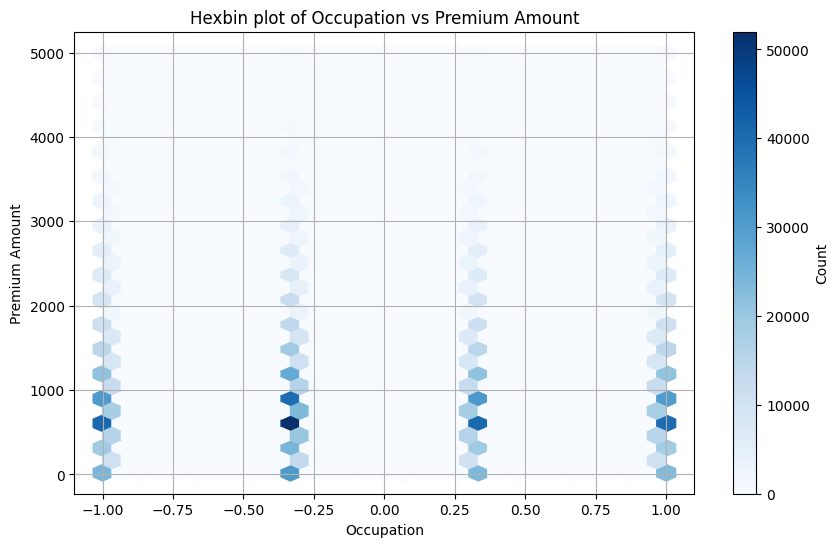

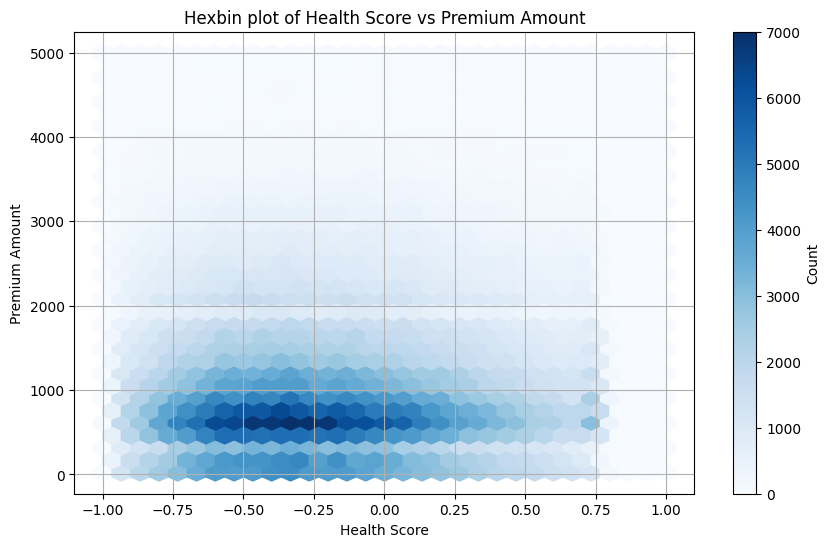

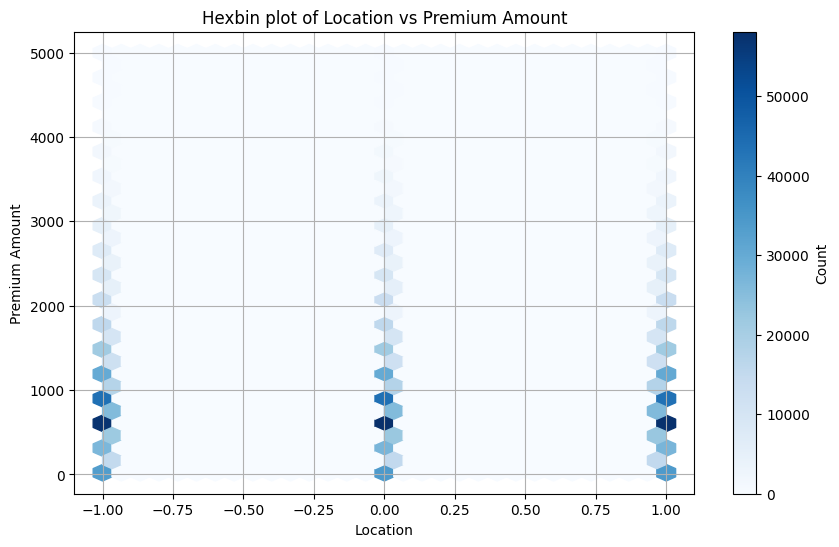

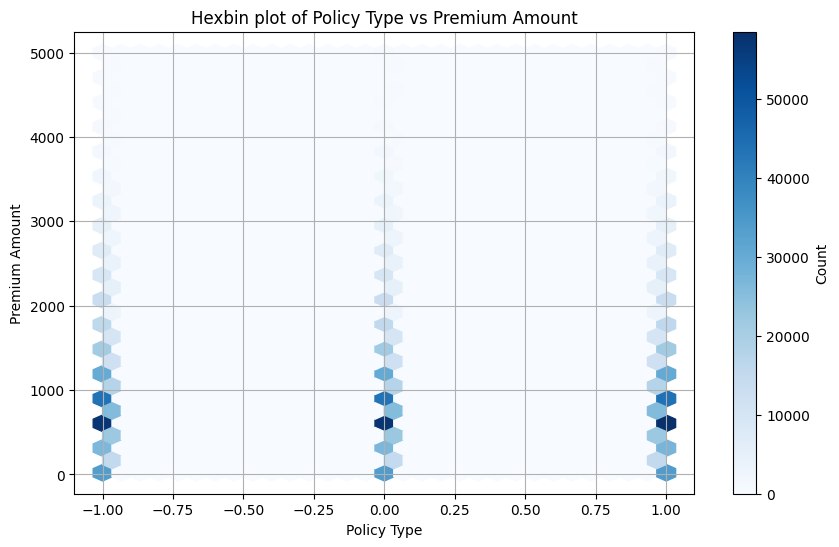

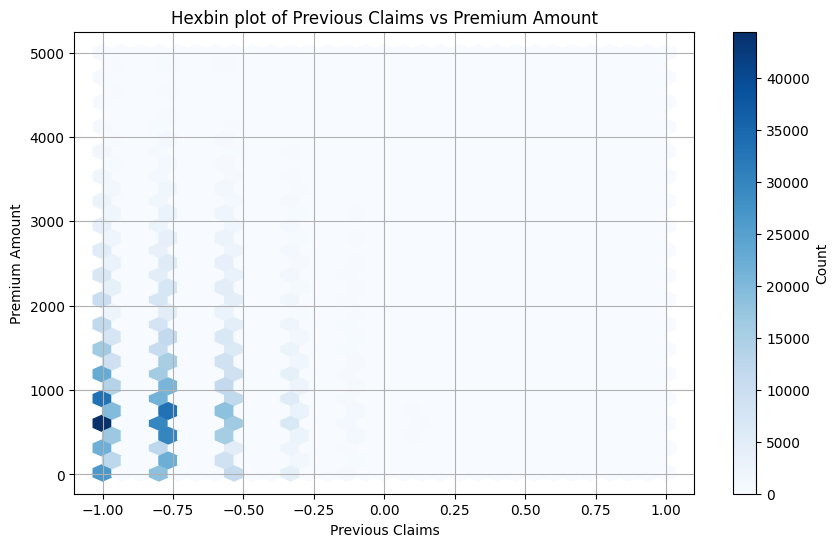

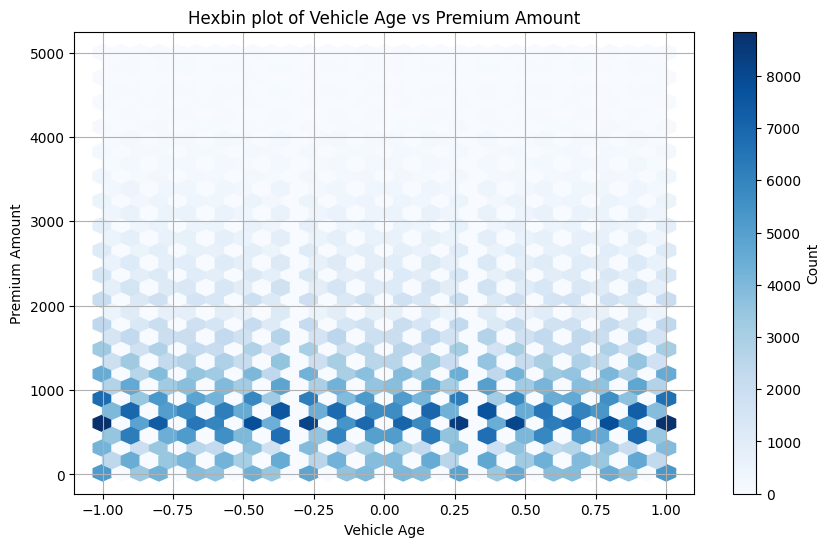

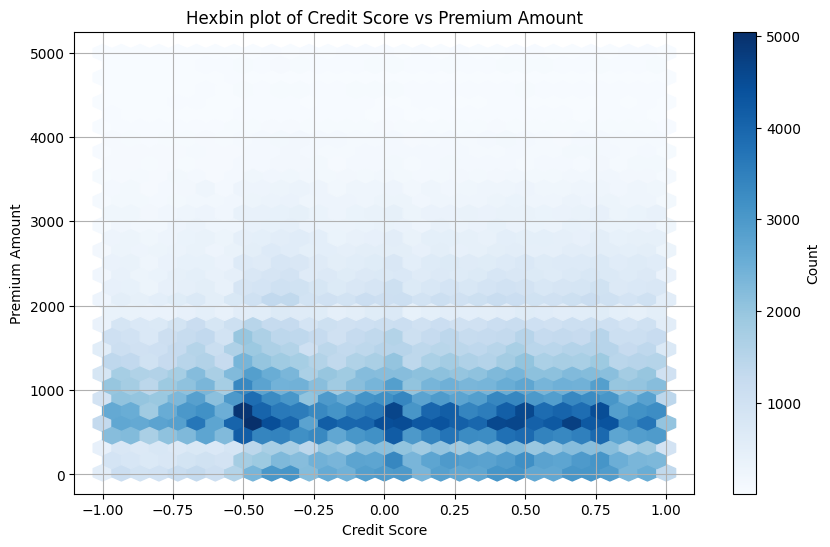

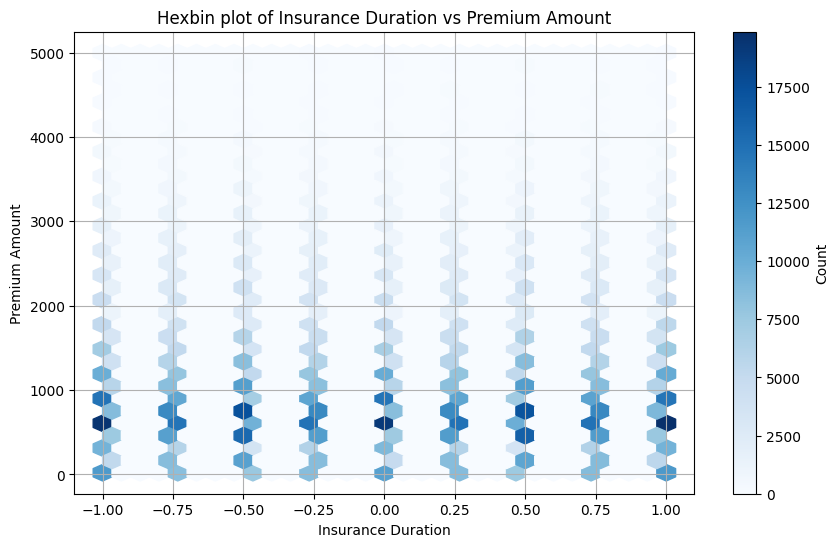

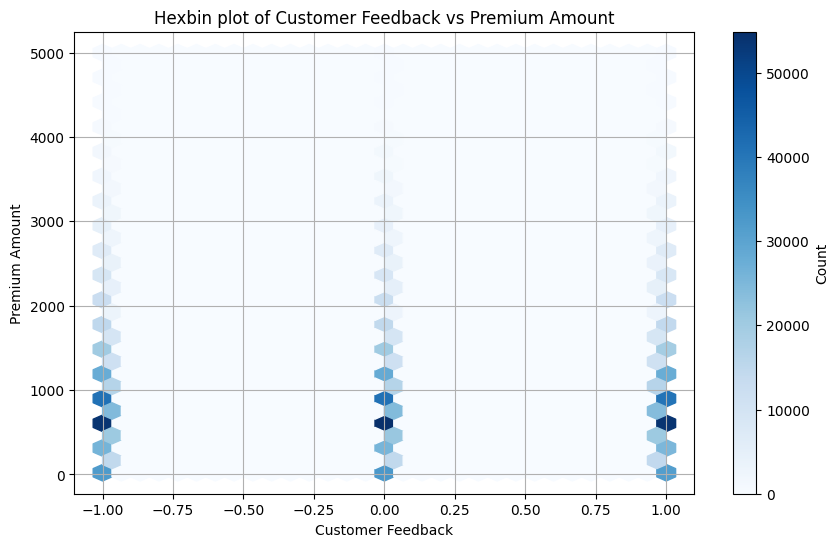

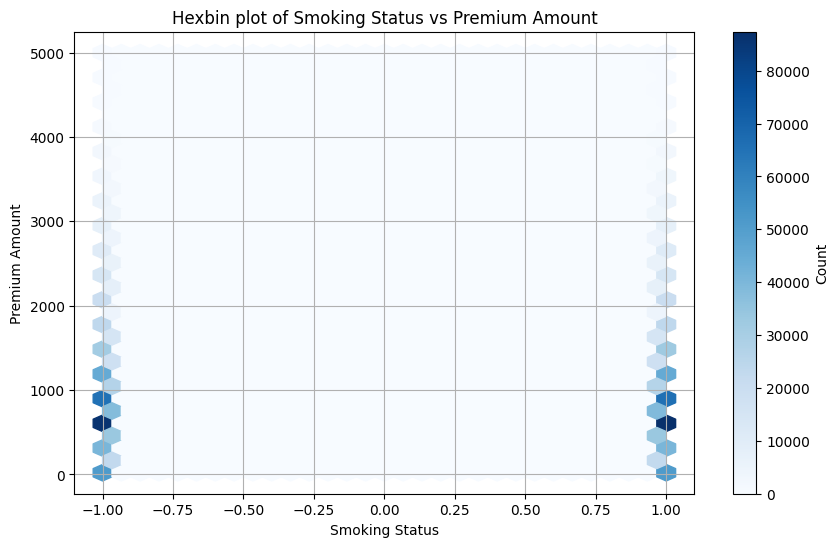

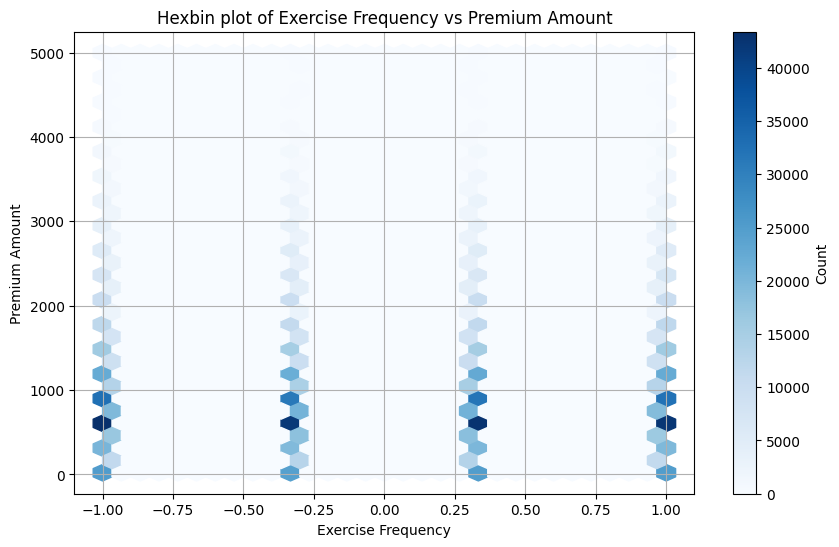

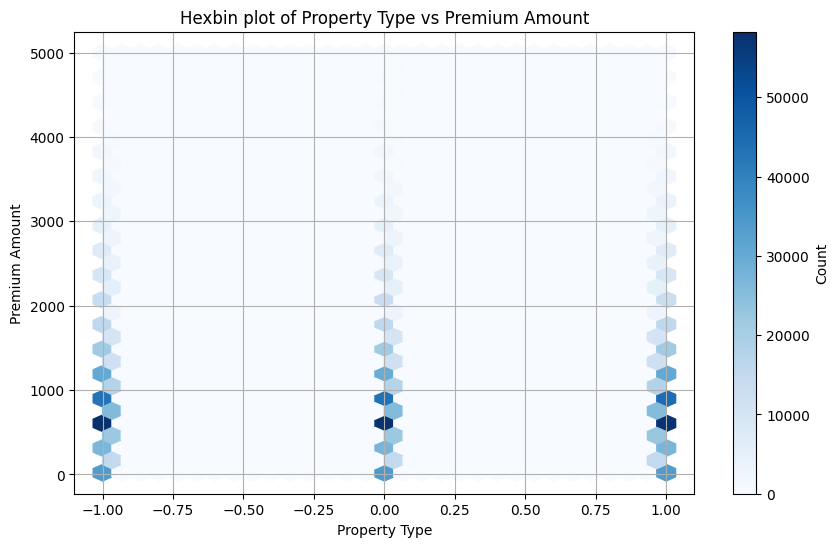

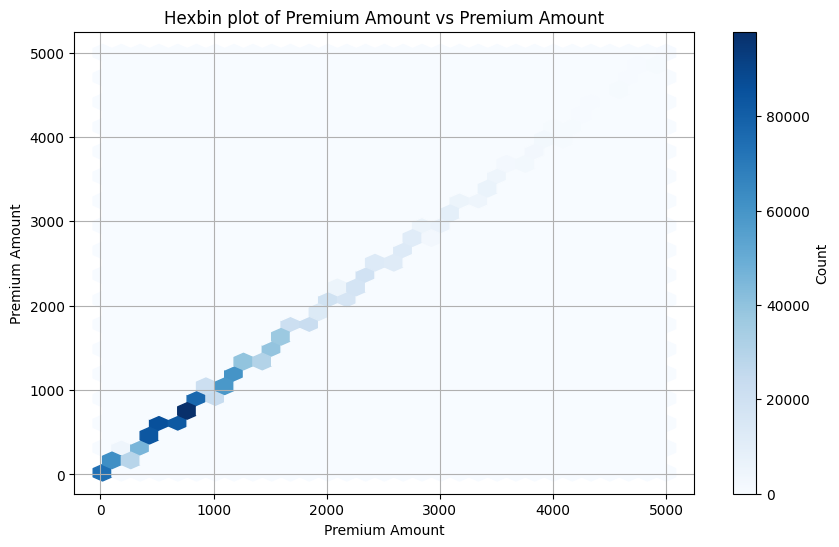

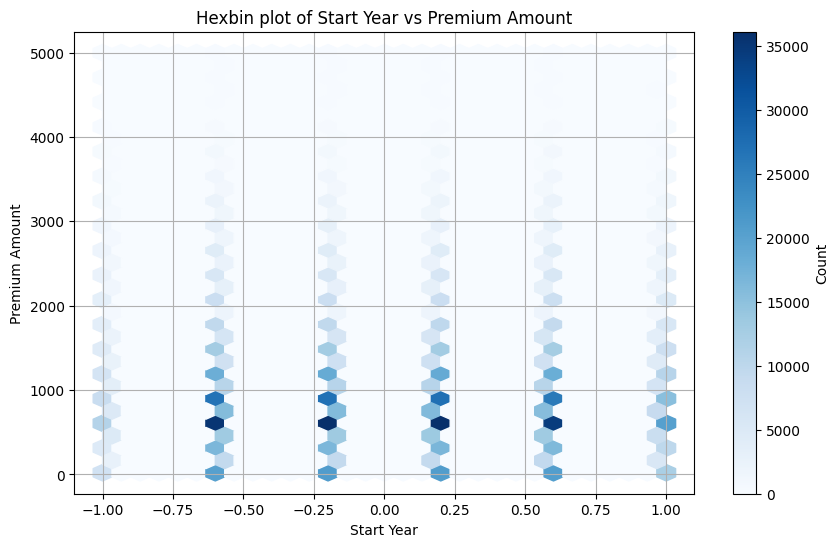

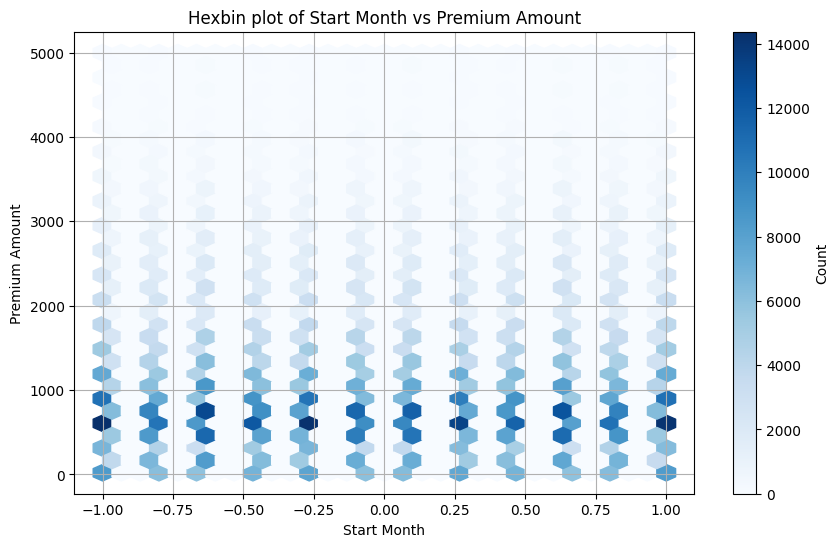

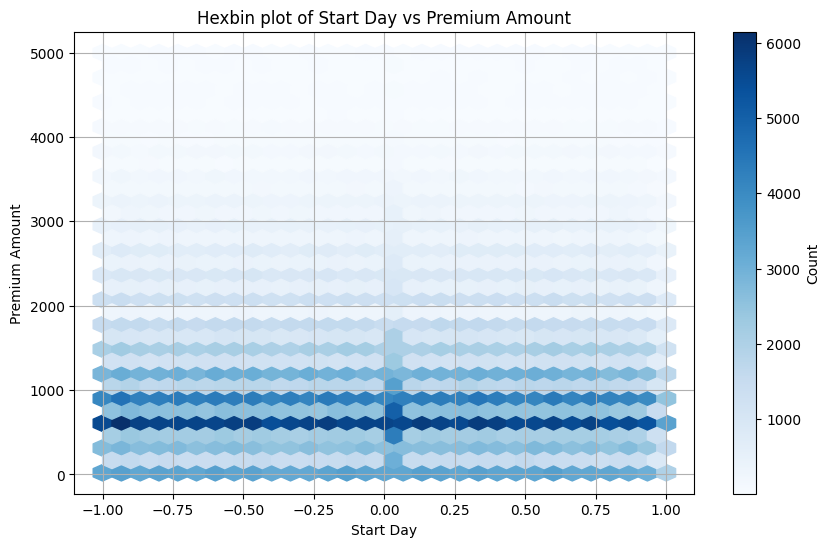

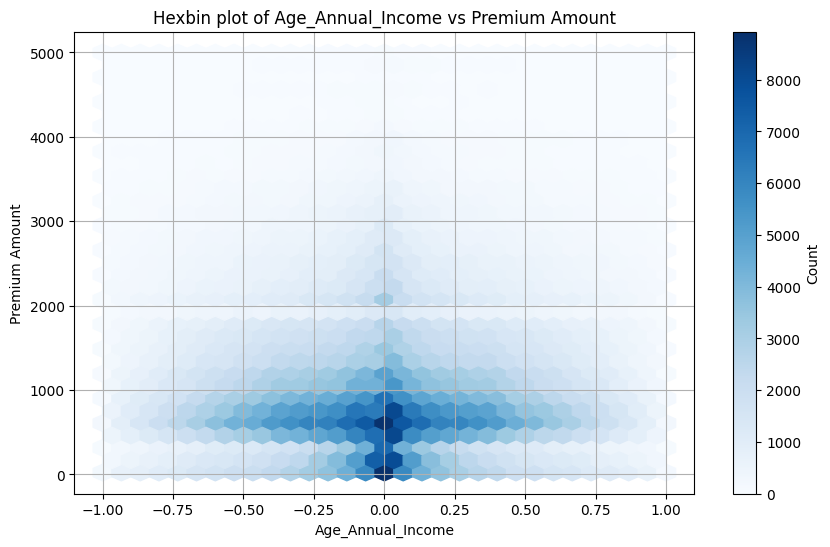

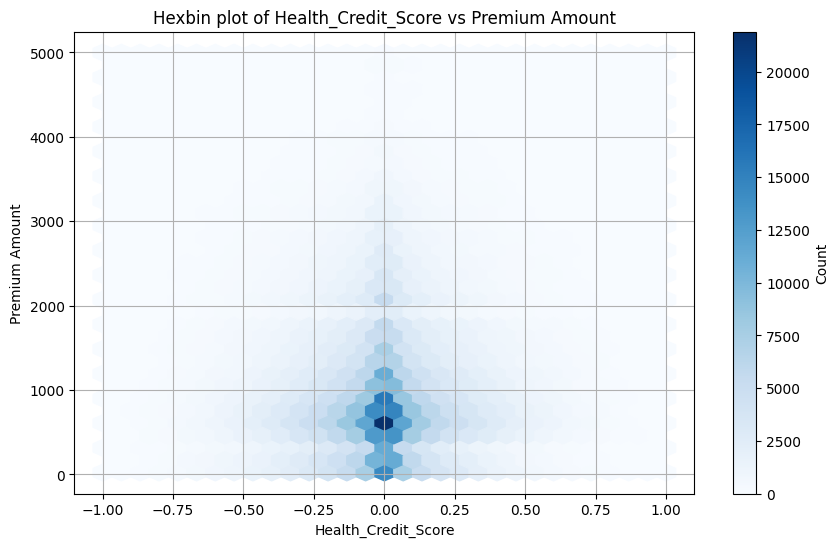

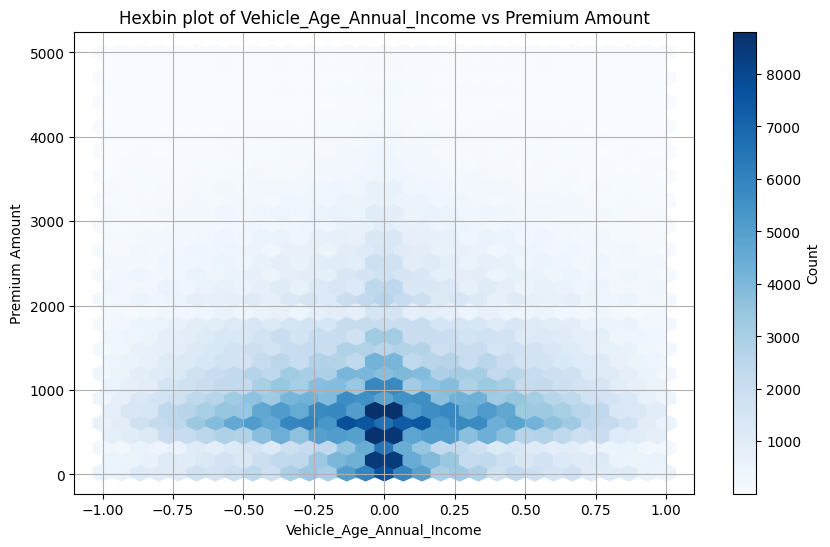

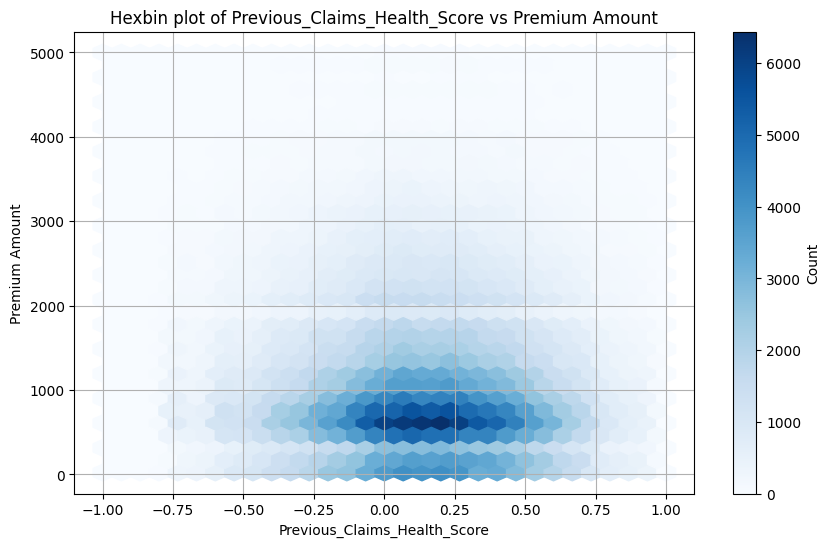

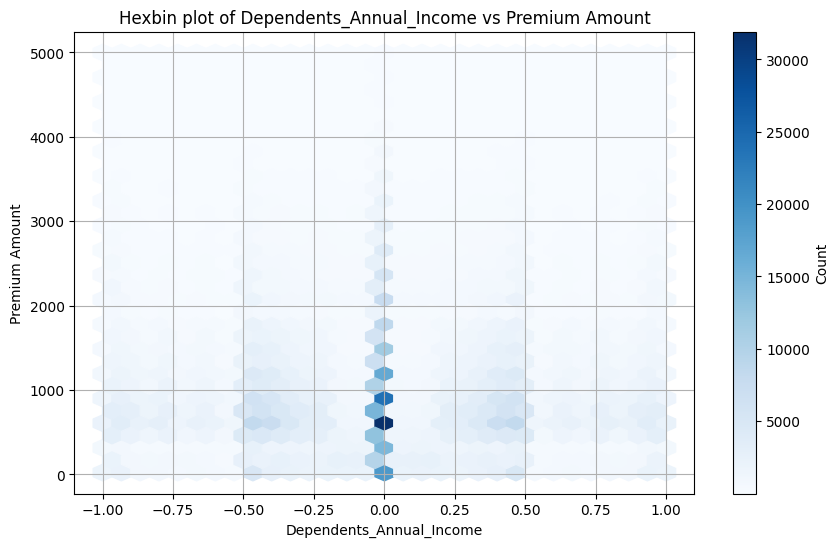

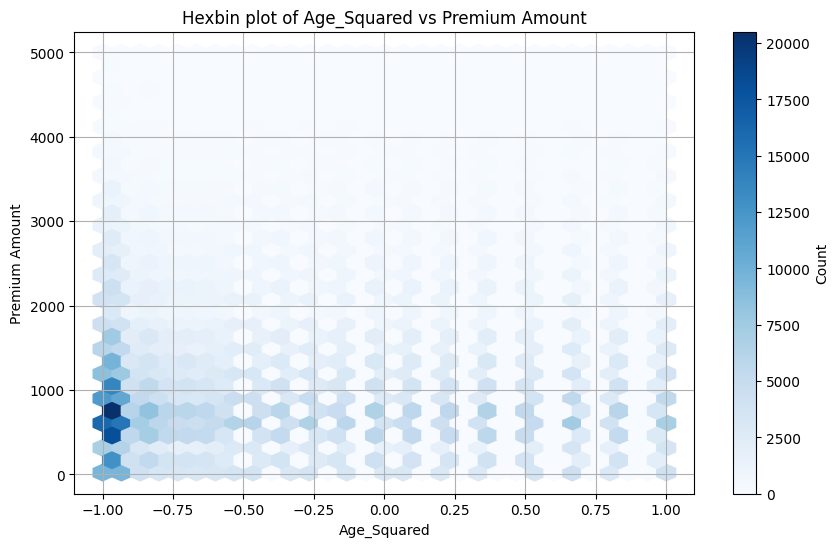

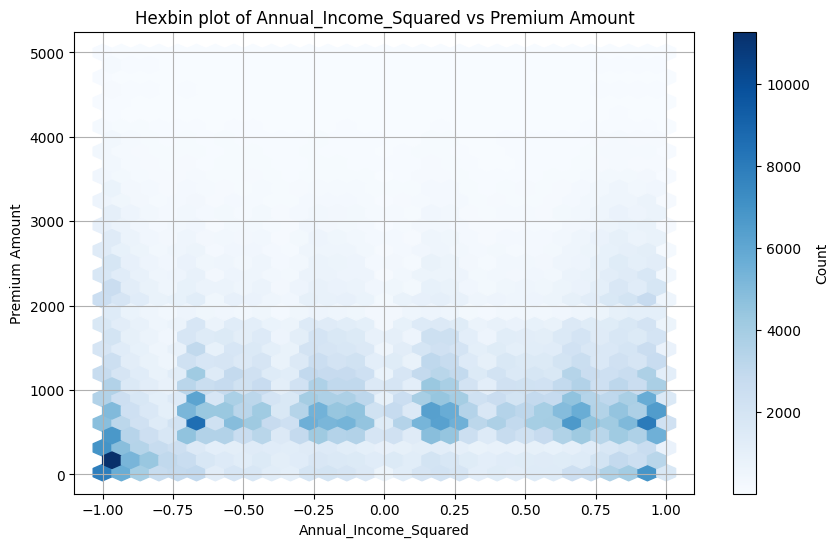

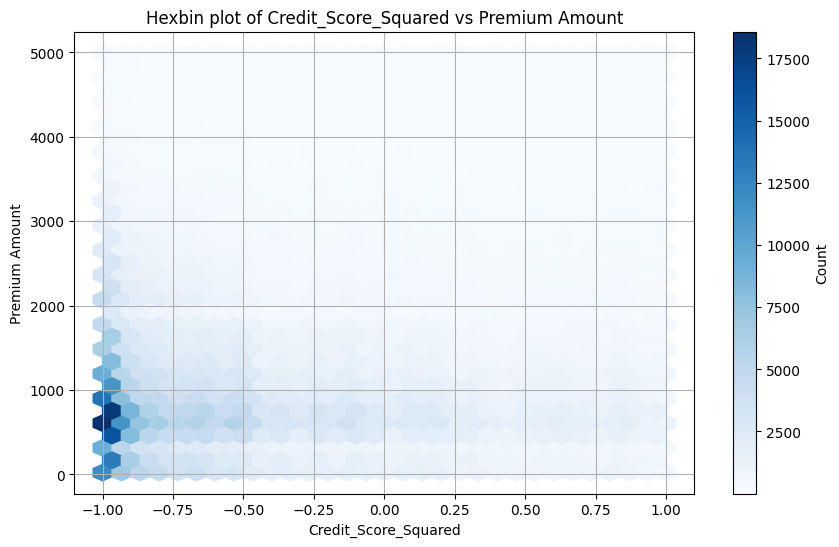

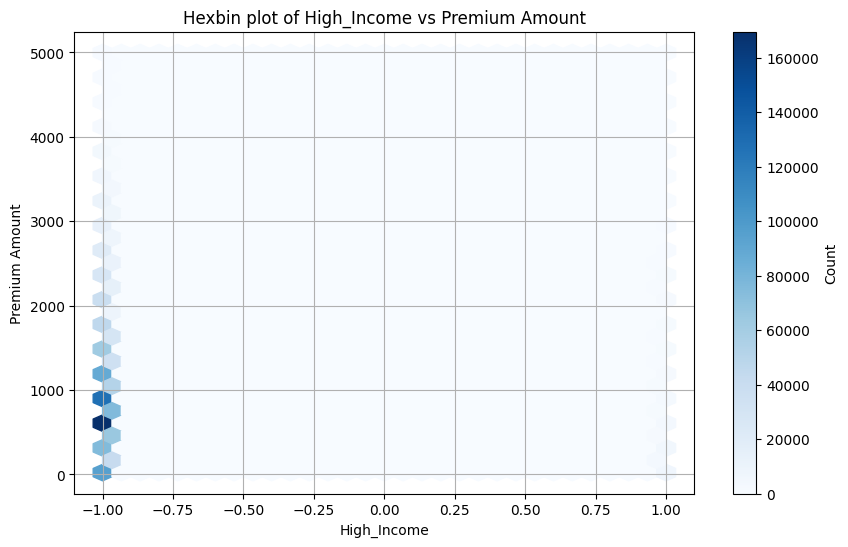

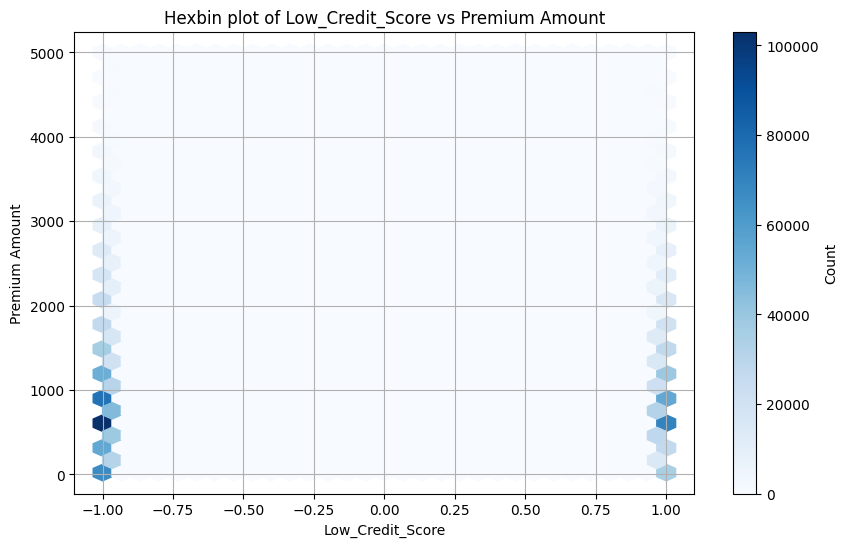

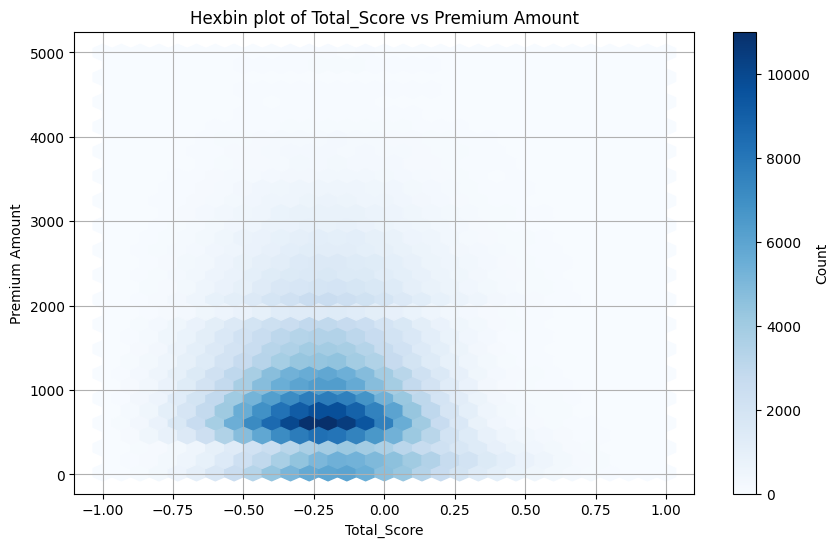

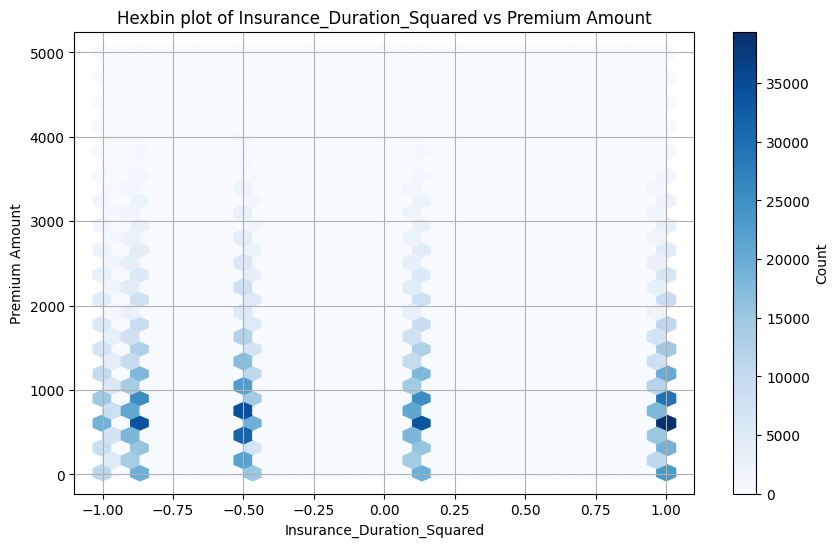

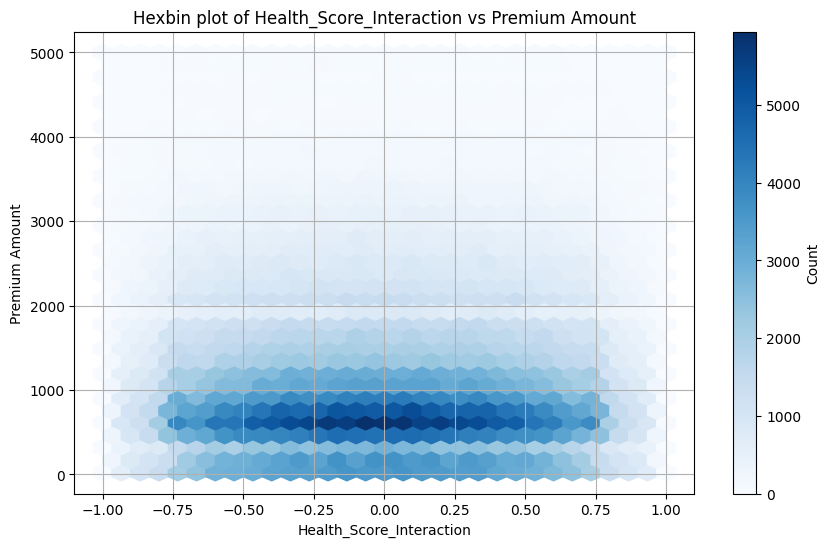

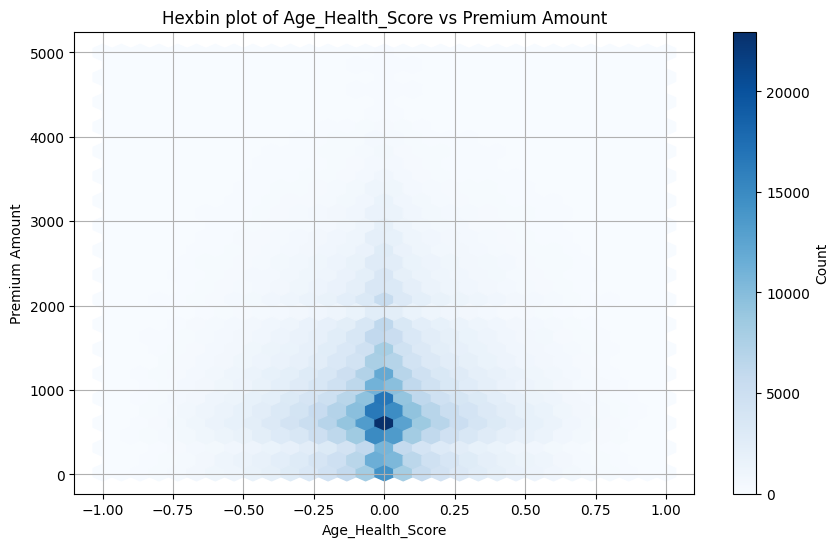

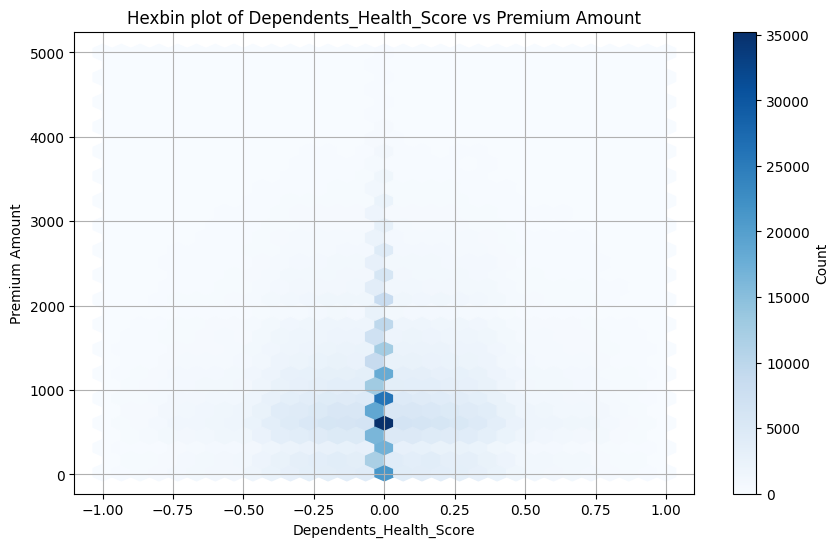

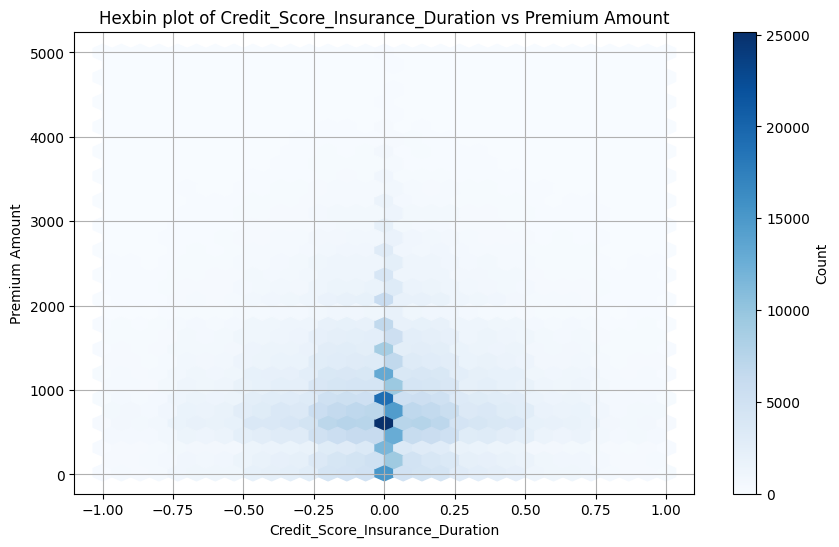

In [4]:
# Split features and target for premium prediction
y_train = train_processed['Premium Amount']
X_train = train_processed


# Plot y_train against each feature in X_train using hexbin for all
for column in X_train.columns:
    plt.figure(figsize=(10, 6))
    plt.hexbin(X_train[column], y_train, gridsize=30, cmap='Blues')
    plt.colorbar(label='Count')
    plt.title(f'Hexbin plot of {column} vs Premium Amount')
    plt.xlabel(column)
    plt.ylabel('Premium Amount')
    plt.grid()
    plt.show()

In [5]:
# Select input features
# input_features = ['Premium Amount','Start Day', 'Start Month', 'Start Year', 'Credit Score', 'Vehicle Age', 'Previous Claims', 'Health Score', 'Annual Income', 'Age','Occupation']
input_features = ['Age','Annual Income','Health Score','Vehicle Age', 'Credit Score','Insurance Duration','Start Day', 'Start Month', 'Start Year','Premium Amount'
                , 'Total_Score', 'Age_Squared', 'Annual_Income_Squared', 'Credit_Score_Squared', 'Health_Score_Interaction', 'Age_Health_Score']
                
X_train_nn = X_train[input_features]
X_train_nn = X_train_nn.dropna()  # Drop rows with NaN values in X_train_nn
y_train_nn = X_train_nn['Premium Amount']
X_train_nn = X_train_nn.drop(columns=['Premium Amount'])



In [7]:

from itertools import combinations

# Store results for the best models
best_models = []

# Loop through all combinations of dropping 3 features
# for dropped_features in combinations(X_train_nn.columns, 1):
for dropped_feature in input_features:
    if dropped_feature == 'Premium Amount':
        continue
    dropped_features = [dropped_feature]
    # Create a new DataFrame without the dropped features
    X_train_split = X_train_nn.drop(columns=list(dropped_features))
    
    # Split the data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_split, y_train_nn, test_size=0.2, random_state=42)

    # Build the neural network model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_split.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Output layer for regression

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')

    # Train the model for only 10 epochs
    model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=10, batch_size=32)

    # Evaluate the model
    y_val_pred = model.predict(X_val_split)
    rmsle = np.sqrt(mean_squared_log_error(y_val_split, y_val_pred))
    
    # Store the model and its performance
    best_models.append((rmsle, dropped_features))

# Sort models by RMSLE and get the best 3
best_models.sort(key=lambda x: x[0])
for i, (rmsle, features) in enumerate(best_models[:3]):
    print(f'Best Model {i+1}: RMSLE = {rmsle}, Dropped Features = {features}')


Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 22s 887us/step - loss: 1.7590 - val_loss: 1.1615
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 857us/step - loss: 1.1510 - val_loss: 1.1522
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 864us/step - loss: 1.1457 - val_loss: 1.1495
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 868us/step - loss: 1.1427 - val_loss: 1.1450
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 865us/step - loss: 1.1380 - val_loss: 1.1452
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 869us/step - loss: 1.1378 - val_loss: 1.1449
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 868us/step - loss: 1.1365 - val_loss: 1.1436
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 870us/step - loss: 1.1367 - val_loss: 1.1441
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 870us/step - loss: 1.1375 - val_loss: 1.1429
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 868us/step - loss: 1.1365 - val_loss: 1.1425
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 3s 471us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 882us/step - loss: 1.8050 - val_loss: 1.1694
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 872us/step - loss: 1.1598 - val_loss: 1.1581
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 902us/step - loss: 1.1528 - val_loss: 1.1614
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 882us/step - loss: 1.1485 - val_loss: 1.1515
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 872us/step - loss: 1.1398 - val_loss: 1.1490
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 866us/step - loss: 1.1397 - val_loss: 1.1471
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 871us/step - loss: 1.1338 - val_loss: 1.1462
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 865us/step - loss: 1.1375 - val_loss: 1.1442
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 863us/step - loss: 1.1365 - val_loss: 1.1433
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 867us/step - loss: 1.1360 - val_loss: 1.1449
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 3s 422us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 873us/step - loss: 1.7216 - val_loss: 1.1662
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 861us/step - loss: 1.1597 - val_loss: 1.1541
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 877us/step - loss: 1.1454 - val_loss: 1.1517
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 862us/step - loss: 1.1422 - val_loss: 1.1478
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 860us/step - loss: 1.1401 - val_loss: 1.1451
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 862us/step - loss: 1.1403 - val_loss: 1.1452
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 861us/step - loss: 1.1370 - val_loss: 1.1452
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 859us/step - loss: 1.1370 - val_loss: 1.1469
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 862us/step - loss: 1.1363 - val_loss: 1.1426
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 860us/step - loss: 1.1373 - val_loss: 1.1429
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 3s 423us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 866us/step - loss: 1.7407 - val_loss: 1.1611
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 864us/step - loss: 1.1564 - val_loss: 1.1507
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 866us/step - loss: 1.1496 - val_loss: 1.1504
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 864us/step - loss: 1.1343 - val_loss: 1.1447
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 872us/step - loss: 1.1436 - val_loss: 1.1436
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 862us/step - loss: 1.1351 - val_loss: 1.1433
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 862us/step - loss: 1.1370 - val_loss: 1.1432
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 861us/step - loss: 1.1383 - val_loss: 1.1422
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 863us/step - loss: 1.1379 - val_loss: 1.1447
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 859us/step - loss: 1.1402 - val_loss: 1.1426
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 2s 417us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 856us/step - loss: 1.7484 - val_loss: 1.1656
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 852us/step - loss: 1.1508 - val_loss: 1.1553
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 857us/step - loss: 1.1477 - val_loss: 1.1523
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 854us/step - loss: 1.1398 - val_loss: 1.1484
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1427 - val_loss: 1.1461
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1418 - val_loss: 1.1448
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 854us/step - loss: 1.1374 - val_loss: 1.1445
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 855us/step - loss: 1.1363 - val_loss: 1.1444
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1381 - val_loss: 1.1439
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 855us/step - loss: 1.1352 - val_loss: 1.1442
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 2s 417us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 860us/step - loss: 1.6971 - val_loss: 1.1653
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 857us/step - loss: 1.1559 - val_loss: 1.1530
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1439 - val_loss: 1.1484
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1408 - val_loss: 1.1448
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 857us/step - loss: 1.1369 - val_loss: 1.1456
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1373 - val_loss: 1.1488
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 857us/step - loss: 1.1370 - val_loss: 1.1450
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 859us/step - loss: 1.1325 - val_loss: 1.1424
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 857us/step - loss: 1.1355 - val_loss: 1.1419
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 854us/step - loss: 1.1375 - val_loss: 1.1417
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 2s 418us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 859us/step - loss: 1.8240 - val_loss: 1.1631
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 854us/step - loss: 1.1537 - val_loss: 1.1508
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 858us/step - loss: 1.1396 - val_loss: 1.1470
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 855us/step - loss: 1.1410 - val_loss: 1.1450
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 855us/step - loss: 1.1410 - val_loss: 1.1435
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 857us/step - loss: 1.1352 - val_loss: 1.1433
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 854us/step - loss: 1.1412 - val_loss: 1.1435
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1352 - val_loss: 1.1429
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 859us/step - loss: 1.1331 - val_loss: 1.1429
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 857us/step - loss: 1.1339 - val_loss: 1.1419
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 2s 415us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 855us/step - loss: 1.7428 - val_loss: 1.1634
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 859us/step - loss: 1.1555 - val_loss: 1.1527
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1442 - val_loss: 1.1474
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1438 - val_loss: 1.1459
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 863us/step - loss: 1.1371 - val_loss: 1.1431
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 882us/step - loss: 1.1397 - val_loss: 1.1473
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 858us/step - loss: 1.1351 - val_loss: 1.1431
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1422 - val_loss: 1.1436
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 854us/step - loss: 1.1408 - val_loss: 1.1421
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1357 - val_loss: 1.1456
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 3s 481us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 22s 888us/step - loss: 1.7680 - val_loss: 1.1631
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 885us/step - loss: 1.1544 - val_loss: 1.1543
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 886us/step - loss: 1.1480 - val_loss: 1.1485
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 888us/step - loss: 1.1418 - val_loss: 1.1484
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 22s 936us/step - loss: 1.1419 - val_loss: 1.1476
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 908us/step - loss: 1.1428 - val_loss: 1.1467
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 888us/step - loss: 1.1396 - val_loss: 1.1454
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 885us/step - loss: 1.1382 - val_loss: 1.1499
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 889us/step - loss: 1.1335 - val_loss: 1.1472
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 883us/step - loss: 1.1373 - val_loss: 1.1469
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 3s 426us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 880us/step - loss: 1.7627 - val_loss: 1.1657
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 875us/step - loss: 1.1599 - val_loss: 1.1539
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 873us/step - loss: 1.1445 - val_loss: 1.1509
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 873us/step - loss: 1.1447 - val_loss: 1.1469
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 868us/step - loss: 1.1392 - val_loss: 1.1442
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 861us/step - loss: 1.1439 - val_loss: 1.1463
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 868us/step - loss: 1.1351 - val_loss: 1.1430
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 866us/step - loss: 1.1386 - val_loss: 1.1440
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 22s 944us/step - loss: 1.1352 - val_loss: 1.1413
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 903us/step - loss: 1.1326 - val_loss: 1.1426
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 22s 893us/step - loss: 1.7097 - val_loss: 1.1606
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 868us/step - loss: 1.1527 - val_loss: 1.1494
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 865us/step - loss: 1.1431 - val_loss: 1.1461
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 863us/step - loss: 1.1450 - val_loss: 1.1501
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 864us/step - loss: 1.1421 - val_loss: 1.1445
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 864us/step - loss: 1.1362 - val_loss: 1.1449
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 864us/step - loss: 1.1408 - val_loss: 1.1437
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 862us/step - loss: 1.1359 - val_loss: 1.1491
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 866us/step - loss: 1.1342 - val_loss: 1.1426
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 863us/step - loss: 1.1337 - val_loss: 1.1431
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 3s 426us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 865us/step - loss: 1.7623 - val_loss: 1.1679
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 868us/step - loss: 1.1609 - val_loss: 1.1622
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 22s 919us/step - loss: 1.1496 - val_loss: 1.1516
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 894us/step - loss: 1.1485 - val_loss: 1.1486
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 861us/step - loss: 1.1404 - val_loss: 1.1485
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 860us/step - loss: 1.1394 - val_loss: 1.1470
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 861us/step - loss: 1.1388 - val_loss: 1.1458
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 862us/step - loss: 1.1393 - val_loss: 1.1460
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 857us/step - loss: 1.1393 - val_loss: 1.1447
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 859us/step - loss: 1.1365 - val_loss: 1.1435
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 2s 415us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 855us/step - loss: 1.7249 - val_loss: 1.1618
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 861us/step - loss: 1.1525 - val_loss: 1.1537
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 857us/step - loss: 1.1419 - val_loss: 1.1477
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1397 - val_loss: 1.1456
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1358 - val_loss: 1.1425
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 862us/step - loss: 1.1343 - val_loss: 1.1430
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1381 - val_loss: 1.1437
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 858us/step - loss: 1.1362 - val_loss: 1.1426
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 858us/step - loss: 1.1364 - val_loss: 1.1418
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 855us/step - loss: 1.1359 - val_loss: 1.1422
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 3s 416us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 860us/step - loss: 1.7204 - val_loss: 1.1644
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 854us/step - loss: 1.1559 - val_loss: 1.1524
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 853us/step - loss: 1.1443 - val_loss: 1.1493
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 851us/step - loss: 1.1438 - val_loss: 1.1445
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 853us/step - loss: 1.1376 - val_loss: 1.1441
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 857us/step - loss: 1.1398 - val_loss: 1.1437
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 855us/step - loss: 1.1393 - val_loss: 1.1437
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 854us/step - loss: 1.1379 - val_loss: 1.1447
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 855us/step - loss: 1.1356 - val_loss: 1.1415
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 856us/step - loss: 1.1364 - val_loss: 1.1450
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 3s 422us/step
Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 871us/step - loss: 1.7759 - val_loss: 1.1658
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 861us/step - loss: 1.1537 - val_loss: 1.1545
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 863us/step - loss: 1.1434 - val_loss: 1.1493
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 862us/step - loss: 1.1433 - val_loss: 1.1449
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 860us/step - loss: 1.1411 - val_loss: 1.1456
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 863us/step - loss: 1.1378 - val_loss: 1.1427
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 863us/step - loss: 1.1378 - val_loss: 1.1442
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 862us/step - loss: 1.1327 - val_loss: 1.1421
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 861us/step - loss: 1.1317 - val_loss: 1.1435
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 20s 860us/step - loss: 1.1326 - val_loss: 1.1444
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 2s 415us/step
Best Model 1: RMSLE = 1.06848929748

In [8]:
# Sort models by RMSLE and get all models
best_models.sort(key=lambda x: x[0])
for i, (rmsle, features) in enumerate(best_models):
    print(f'Best Model {i+1}: RMSLE = {rmsle}, Dropped Features = {features}')

Best Model 1: RMSLE = 1.068489297480867, Dropped Features = ['Insurance Duration']
Best Model 2: RMSLE = 1.0685974918733565, Dropped Features = ['Start Day']
Best Model 3: RMSLE = 1.0687316345659468, Dropped Features = ['Credit_Score_Squared']
Best Model 4: RMSLE = 1.0688700241439901, Dropped Features = ['Age']
Best Model 5: RMSLE = 1.0689164883728173, Dropped Features = ['Vehicle Age']
Best Model 6: RMSLE = 1.0689284857483838, Dropped Features = ['Total_Score']
Best Model 7: RMSLE = 1.069086098695371, Dropped Features = ['Health Score']
Best Model 8: RMSLE = 1.069167807267174, Dropped Features = ['Age_Squared']
Best Model 9: RMSLE = 1.0693290050758595, Dropped Features = ['Annual_Income_Squared']
Best Model 10: RMSLE = 1.069684480794706, Dropped Features = ['Credit Score']
Best Model 11: RMSLE = 1.0697889949983872, Dropped Features = ['Age_Health_Score']
Best Model 12: RMSLE = 1.0699913245600456, Dropped Features = ['Annual Income']
Best Model 13: RMSLE = 1.0700531812257745, Dropped F

In [9]:



# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_nn, y_train_nn, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_split.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # Output layer for regression



# Compile the model
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=10, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
y_val_pred = model.predict(X_val_split)
rmsle = np.sqrt(mean_squared_log_error(y_val_split, y_val_pred))
print(f'Root Mean Squared Logarithmic Error on validation set: {rmsle}')



Epoch 1/10


c:\Users\Ghaith\Desktop\ML\projects\venv12\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23580/23580 ━━━━━━━━━━━━━━━━━━━━ 22s 906us/step - loss: 1.8031 - val_loss: 1.1615
Epoch 2/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 870us/step - loss: 1.1486 - val_loss: 1.1522
Epoch 3/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 874us/step - loss: 1.1472 - val_loss: 1.1486
Epoch 4/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 889us/step - loss: 1.1401 - val_loss: 1.1492
Epoch 5/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 881us/step - loss: 1.1405 - val_loss: 1.1447
Epoch 6/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 891us/step - loss: 1.1393 - val_loss: 1.1432
Epoch 7/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 898us/step - loss: 1.1360 - val_loss: 1.1435
Epoch 8/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 877us/step - loss: 1.1314 - val_loss: 1.1435
Epoch 9/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 868us/step - loss: 1.1345 - val_loss: 1.1439
Epoch 10/10
23580/23580 ━━━━━━━━━━━━━━━━━━━━ 21s 879us/step - loss: 1.1354 - val_loss: 1.1426
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
Root Mean Squared Logarithmic Error

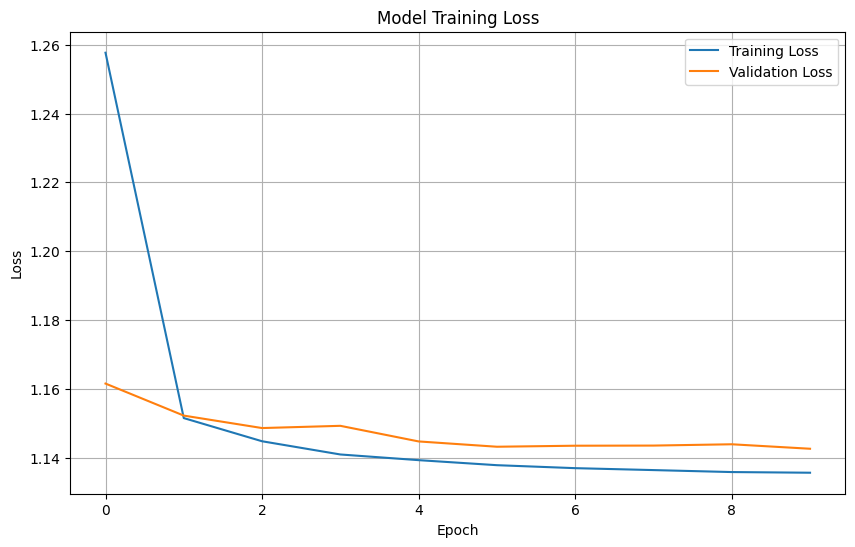

In [10]:


# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()


In [12]:


nan_counts = test_processed.isna().sum()
print("Number of NaNs in each column of test_processed:")
print(nan_counts)


Number of NaNs in each column of test_processed:
Age                                 12489
Gender                                  0
Annual Income                       29860
Marital Status                      12336
Number of Dependents                73130
Education Level                         0
Occupation                              0
Health Score                        49449
Location                                0
Policy Type                             0
Previous Claims                    242802
Vehicle Age                             3
Credit Score                        91451
Insurance Duration                      2
Customer Feedback                   52276
Smoking Status                          0
Exercise Frequency                      0
Property Type                           0
Start Year                              0
Start Month                             0
Start Day                               0
Age_Annual_Income                   41868
Health_Credit_Score        

In [14]:
test_features = ['Age','Annual Income','Health Score','Vehicle Age', 'Credit Score','Insurance Duration','Start Day', 'Start Month', 'Start Year'
                , 'Total_Score', 'Age_Squared', 'Annual_Income_Squared', 'Credit_Score_Squared', 'Health_Score_Interaction', 'Age_Health_Score']
                
X_test_nn = test_processed[test_features]
X_test_nn.fillna(X_test_nn.mean(), inplace=True)


C:\Users\Ghaith\AppData\Local\Temp\ipykernel_19140\139096885.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_nn.fillna(X_test_nn.mean(), inplace=True)


In [15]:
# Make predictions on test data using the model
test_predictions = model.predict(X_test_nn)

# Create DataFrame with ID and predictions
results_df = pd.DataFrame({
    'id': test_df['id'],
    'Premium Amount': test_predictions.flatten()  # Corrected to use test_predictions
})

# Save predictions to CSV
results_df.to_csv('Submission.csv', index=False)

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 11s 425us/step
